In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### image dataset load

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

data_dir = r'/content/drive/My Drive/기업프로젝트-라젠/data/40, 320'

IMAGE_SIZE = (224,224)
BATCH_SIZE = 128

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 13120 files belonging to 320 classes.
Using 10496 files for training.
Found 13120 files belonging to 320 classes.
Using 2624 files for validation.


In [ ]:
print(train_ds)
print(val_ds)

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


### 데이터 정규화

In [ ]:
from tensorflow.keras import layers

# 0~1 사이의 값을 가지도록 조정
def normalization_dataset(dataset):
    normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
    normalized_ds = dataset.map(lambda x, y: (normalization_layer(x), y))
    return normalized_ds 

train_ds = normalization_dataset(train_ds)
val_ds = normalization_dataset(val_ds) 
print(train_ds)
print(val_ds)

<MapDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
<MapDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>


### 성능을위한 데이터 세트 구성

In [ ]:
# cache() 첫 번째 에포크 동안 디스크에서로드 된 이미지를 메모리에 보관합니다. 
# prefetch 학습 중에 데이터 전처리 및 모델 실행과 겹칩니다

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


### tensorflow module load

In [ ]:
import tensorflow_hub as hub
import tensorflow_addons as tfa
 
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Lambda, MaxPooling2D, Conv2D
from tensorflow.keras.optimizers import Adam, SGD, Adagrad

from tensorflow.keras.callbacks import EarlyStopping

### 모델 load, train

In [ ]:
# resnet_50
hub_url = "https://tfhub.dev/tensorflow/resnet_50/classification/1"
hub_layer = hub.KerasLayer(hub_url,
                           input_shape=IMAGE_SIZE + (3,),
                           trainable=True)

# model구축
# triplets 128벡터값을 위한 dense출력값을 128로 설정, activation = None
# deep architecture이후 l2정규화
model = Sequential()
model.add(hub_layer)
model.add(Dense(128, activation=None))
model.add(Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))  

model.summary()

# 모델 complie
adam = Adam(lr=0.001, decay=1e-6)
model.compile(optimizer=adam, loss=tfa.losses.TripletSemiHardLoss())

# SGD = SGD(lr=0.05)
# model.compile(optimizer=SGD, loss=tfa.losses.TripletSemiHardLoss())

# Adagrad = Adagrad(lr=0.01, epsilon=1e-6)
# model.compile(optimizer=adam, loss=tfa.losses.TripletSemiHardLoss())

# earlystopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

# 모델 학습
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs=1000,
                    callbacks=[early_stopping]
                    )  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              25612201  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               128256    
_________________________________________________________________
lambda_1 (Lambda)            (None, 128)               0         
Total params: 25,740,457
Trainable params: 25,687,337
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/1000
 2/82 [..............................] - ETA: 25s - loss: 1.4469WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2321s vs `on_train_batch_end` time: 0.3929s). Check your callbacks.


82/82 [==============================] - 63s 764ms/step - loss: 1.5109 - val_loss: 1.5203
Epoch 2/1000
82/82 [==============================] - 55s 669ms/step - loss: 1.5196 - val_loss: 1.4997
Epoch 3/1000
82/82 [==============================] - 55s 670ms/step - loss: 1.4719 - val_loss: 1.4219
Epoch 4/1000
82/82 [==============================] - 55s 669ms/step - loss: 1.4670 - val_loss: 1.4681
Epoch 5/1000
82/82 [==============================] - 55s 669ms/step - loss: 1.4576 - val_loss: 1.4459
Epoch 6/1000
82/82 [==============================] - 55s 670ms/step - loss: 1.4372 - val_loss: 1.4497
Epoch 7/1000
82/82 [==============================] - 55s 669ms/step - loss: 1.4176 - val_loss: 1.4119
Epoch 8/1000
82/82 [==============================] - 55s 669ms/step - loss: 1.3949 - val_loss: 1.3819
Epoch 9/1000
82/82 [==============================] - 55s 669ms/step - loss: 1.3668 - val_loss: 1.3538
Epoch 10/1000
82/82 [==============================] - 55s 669ms/step - loss: 1.3474 -

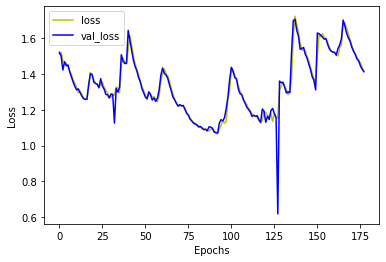

In [ ]:
# loss 그래프
import matplotlib.pyplot as plt
plt.figure("val_graph")
plt.plot(history.history['loss'], 'y', label='loss')
plt.plot(history.history['val_loss'],'b', label='val_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
model.save('/content/drive/My Drive/기업프로젝트-라젠/model/resnet_50-2.h5')

In [ ]:
# resnet_50
hub_url = "https://tfhub.dev/tensorflow/resnet_50/classification/1"
hub_layer = hub.KerasLayer(hub_url,
                           input_shape=IMAGE_SIZE + (3,),
                           trainable=True)

# model구축
# triplets 128벡터값을 위한 dense출력값을 128로 설정, activation = None
# deep architecture이후 l2정규화
model = Sequential()
model.add(hub_layer)
model.add(Dense(128, activation=None))
model.add(Lambda(lambda x: tf.math.l2_normalize(x, axis=1)))  

model.summary()

# 모델 complie
adam = Adam(lr=0.001, decay=1e-6)
model.compile(optimizer=adam, loss=tfa.losses.TripletSemiHardLoss())

# SGD = SGD(lr=0.05)
# model.compile(optimizer=SGD, loss=tfa.losses.TripletSemiHardLoss())

# Adagrad = Adagrad(lr=0.01, epsilon=1e-6)
# model.compile(optimizer=adam, loss=tfa.losses.TripletSemiHardLoss())

# earlystopping
# early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

# 모델 학습
history = model.fit(train_ds,
                    validation_data = val_ds,
                    epochs=1000,
                    # callbacks=[early_stopping]
                    )  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1001)              25612201  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               128256    
_________________________________________________________________
lambda_2 (Lambda)            (None, 128)               0         
Total params: 25,740,457
Trainable params: 25,687,337
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/1000
 2/82 [..............................] - ETA: 40s - loss: 1.4477WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2353s vs `on_train_batch_end` time: 0.3940s). Check your callbacks.


82/82 [==============================] - 56s 687ms/step - loss: 1.5080 - val_loss: 1.5284
Epoch 2/1000
82/82 [==============================] - 55s 675ms/step - loss: 1.5037 - val_loss: 1.4934
Epoch 3/1000
82/82 [==============================] - 55s 676ms/step - loss: 1.4711 - val_loss: 1.4463
Epoch 4/1000
82/82 [==============================] - 55s 675ms/step - loss: 1.4262 - val_loss: 1.3995
Epoch 5/1000
82/82 [==============================] - 55s 675ms/step - loss: 1.3854 - val_loss: 1.3633
Epoch 6/1000
82/82 [==============================] - 55s 675ms/step - loss: 1.3612 - val_loss: 1.3547
Epoch 7/1000
82/82 [==============================] - 55s 675ms/step - loss: 1.3358 - val_loss: 1.3115
Epoch 8/1000
82/82 [==============================] - 55s 675ms/step - loss: 1.3048 - val_loss: 1.2885
Epoch 9/1000
82/82 [==============================] - 55s 675ms/step - loss: 1.2809 - val_loss: 1.2688
Epoch 10/1000
82/82 [==============================] - 55s 675ms/step - loss: 1.2610 -

In [ ]:
# loss 그래프
plt.figure("val_graph")
plt.plot(history.history['loss'], 'y', label='loss')
plt.plot(history.history['val_loss'],'b', label='val_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

NameError: ignored